In [2]:
from pyDOE2 import lhs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [3]:
# =================================================================================================
# Function for constructing a DataFrame from a matrix with floating point numbers between 0 and 1
# =================================================================================================

def construct_df_from_random_matrix(x,factor_array):
    """
    This function constructs a DataFrame out of matrix x and factor_array, both of which are assumed to be numpy arrays.
    It projects the numbers in the x (which is output of a design-of-experiment build) to the factor array ranges.
    Here factor_array is assumed to have only min and max ranges.
    Matrix x is assumed to have numbers ranging from 0 to 1 only.
    """
    
    row_num=x.shape[0] # Number of rows in the matrix x
    col_num=x.shape[1] # Number of columns in the matrix x
    
    empty=np.zeros((row_num,col_num))  
    
    def simple_substitution(idx,factor_list):
        alpha=np.abs(factor_list[1]-factor_list[0])
        beta=idx
        return factor_list[0]+(beta*alpha)
        
    for i in range(row_num):
        for j in range(col_num):
            empty[i,j] = simple_substitution(x[i,j],factor_array[j])
        
    return pd.DataFrame(data=empty)

# ====================================================================================
# Function for building simple Latin Hypercube from a dictionary of process variables
# ====================================================================================

def build_lhs(factor_level_ranges, num_samples=None, prob_distribution=None):
    """
    Builds a Latin Hypercube design dataframe from a dictionary of factor/level ranges.
    Only min and max values of the range are required.
    Example of the dictionary:
    {'Pressure':[50,70],'Temperature':[290, 350],'Flow rate':[0.9,1.0]}
    num_samples: Number of samples to be generated
    prob_distribution: Analytical probability distribution to be applied over the randomized sampling. 
    Takes strings like: 'Normal', 'Poisson', 'Exponential', 'Beta', 'Gamma'
    Latin hypercube sampling (LHS) is a form of stratified sampling that can be applied to multiple variables. The method commonly used to reduce the number or runs necessary for a Monte Carlo simulation to achieve a reasonably accurate random distribution. LHS can be incorporated into an existing Monte Carlo model fairly easily, and work with variables following any analytical probability distribution.
    """
    for key in factor_level_ranges:
        if len(factor_level_ranges[key])!=2:
            factor_level_ranges[key][1]=factor_level_ranges[key][-1]
            factor_level_ranges[key]=factor_level_ranges[key][:2]
            print(f"{key} had more than two levels. Assigning the end point to the high level.")
    
    factor_count=len(factor_level_ranges)
    factor_lists=[]
    
    if num_samples==None:
        num_samples=factor_count
    
    for key in factor_level_ranges:
        factor_lists.append(factor_level_ranges[key])
    
    x = lhs(n=factor_count,samples=num_samples)
    factor_lists=np.array(factor_lists)
    
    df = construct_df_from_random_matrix(x,factor_lists)
    df.columns=factor_level_ranges.keys()
    return df


In [13]:
DICT_VARS = {'Mw (100kDa)':[1,6],'MR TrFE':[0, 33],'MR CTFE':[0, 33],'BaTiO3 wt%':[0.2,0.8], 'NP size (nm)':[50,200], 'Anneal Temp. (C)':[60,100], 'Poling Voltage (MV/m)':[20,50]}
NUM_SAMPLES = 20
design = build_lhs(DICT_VARS, num_samples=NUM_SAMPLES)

In [15]:
particle_size = []

for ps in design['NP size (nm)']:
    if ps < 90:
        particle_size.append(50)
    elif ps > 150:
        particle_size.append(200)
    else:
        particle_size.append(100)

design['Mw (100kDa)'] = np.round(design['Mw (100kDa)'],1)
design['MR TrFE'] = np.round(design['MR TrFE'],0)
design['MR CTFE'] = np.round(design['MR CTFE'],0)
design['BaTiO3 wt%'] = np.round(design['BaTiO3 wt%'],2)
design['NP size (nm)'] = particle_size
design['Anneal Temp. (C)'] = np.round(design['Anneal Temp. (C)'],0)
design['Poling Voltage (MV/m)'] = np.round(design['Poling Voltage (MV/m)'],0)

design

,Mw (100kDa),MR TrFE,MR CTFE,BaTiO3 wt%,NP size (nm),Anneal Temp. (C),Poling Voltage (MV/m),particle size (nm)
0,3.0,31.0,1.0,0.44,200,62.0,45.0,200
1,5.6,11.0,32.0,0.64,50,71.0,26.0,50
2,4.5,4.0,10.0,0.50,100,76.0,34.0,100
3,5.9,23.0,20.0,0.68,50,63.0,32.0,50
4,5.1,20.0,12.0,0.24,200,95.0,49.0,200
5,4.7,26.0,3.0,0.35,100,82.0,36.0,100
6,4.9,23.0,17.0,0.35,50,97.0,24.0,50
7,1.8,7.0,20.0,0.58,100,85.0,31.0,100
8,1.5,1.0,31.0,0.74,100,68.0,29.0,100
9,4.0,17.0,23.0,0.45,50,74.0,26.0,50


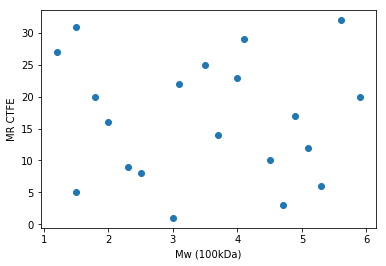

In [16]:
plt.scatter(design['Mw (100kDa)'],design['MR CTFE'])
plt.xlabel('Mw (100kDa)')
plt.ylabel('MR CTFE')
plt.show()

In [17]:
nVars = 8
levels = 3
levels**nVars

6561